In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

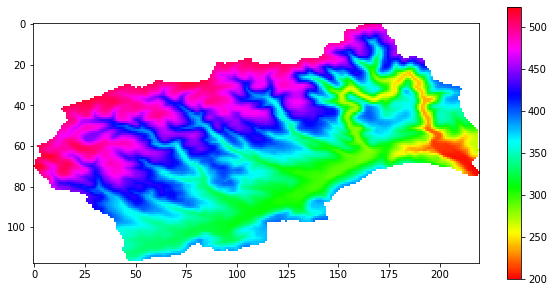

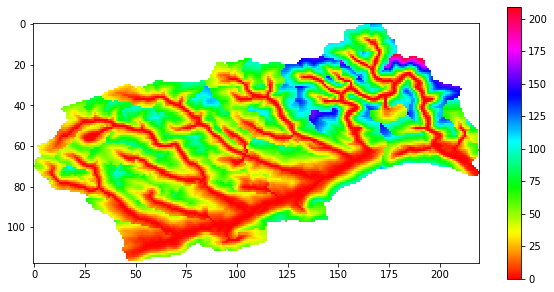

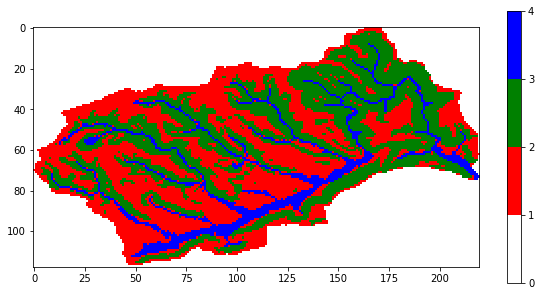

In [10]:
DEM=np.genfromtxt('wark_data/dem.asc',  dtype=float, autostrip=True) # Digital elevation model
slope=np.genfromtxt('wark_data/slope.asc',  dtype=float, autostrip=True)
hand=np.genfromtxt('wark_data/HAND.asc',  dtype=float, autostrip=True) # Height above nearest drainaga
basin=np.genfromtxt('wark_data/basin.asc',  dtype=float, autostrip=True) 

#plot DEM
plt.figure(1, figsize=(10, 5))
DEM[DEM==-9999]=np.nan
plt.imshow(DEM, cmap='hsv')
plt.colorbar()
 
#plot HAND
plt.figure(2, figsize=(10, 5))
hand[hand==-9999]=np.nan
plt.imshow(hand, cmap='hsv')
plt.colorbar()

#make landscape classification
lc_hillslope = (np.array(hand) > 4.7) & (np.array(slope) > 11) 
lc_plateau = (np.array(hand) > 4.7) & (np.array(slope) <= 11)
lc_wetland = np.array(hand) <= 4.7
basin = np.array(basin) > 0

#calculate percentages
hillslope_per = float(np.sum(lc_hillslope)) / np.sum(basin)
wetland_per = float(np.sum(lc_wetland)) / np.sum(basin)
plateau_per = float(np.sum(lc_plateau)) / np.sum(basin)

#matrics with landscape classes
landscapes = np.zeros((118, 220))
landscapes[lc_plateau] = 1
landscapes[lc_hillslope] = 2
landscapes[lc_wetland] = 3

#plot landscapes
cmap = mpl.colors.ListedColormap(['white', 'red', 'green', 'blue'])
bounds = [0, 1, 2, 3, 4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.figure(3, figsize=(10, 5))
plt.imshow(landscapes, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [3]:
def Weigfun(T_lag): 
    n_max = int(np.ceil(T_lag))
    if n_max == 1: 
        Weigths = float(1)
    else:
        Weigths = np.zeros(n_max)

        th = T_lag/2
        nh = int(np.floor(th))
        for i in range(0, nh): 
            Weigths[i] = (float(i+1) - 0.5) / th    
        
        i=nh

        Weigths[i] = (1 + (float(i+1) - 1) / th) * (th - int(np.floor(th))) / 2 + (1 + (T_lag - float(i+1)) / th) * (int(np.floor(th)) + 1 - th) / 2
        for i in range(nh+1, int(np.floor(T_lag))):
            Weigths[i] = (T_lag - float(i+1) + 0.5) / th

        if T_lag > int(np.floor(T_lag)):
            Weigths[int(np.floor(T_lag))] = (T_lag - int(np.floor(T_lag))) ** 2 / (2 * th)

        Weigths = Weigths / sum(Weigths)

    return(Weigths)

In [4]:
def plateau(timestep, Par, forcing, Fluxes, States):
#HBVpareto Calculates values of 3 objective functions for HBV model

    I_max = Par[0] # Maximum interception storage
    C_e = Par[1]
    S_u_max = Par[2]  # Maximum storage in unsaturated root zone
    beta = Par[3] # Shape factor
    P_max = Par[4] # Maximum percolation rate
    K_f = Par[5] # Storage coefficient of fast reservoir
    f_EI = 1
    
    Q_o = forcing[:, 0] # Recorderd discharge [mm/d]
    P = forcing[:, 1] # Precipitation [mm/d]
    E_p = forcing[:, 2] # Potential evaporation [mm/d]

    S_i = States[:, 0] # Intercepotion reservoir
    S_u = States[:, 1] # Unsaturated reservoir
    S_f = States[:, 2] # Fast reservoir

    E_i = Fluxes[:, 0] # Interception evapoartation
    E_a = Fluxes[:, 1] # Actual evaporation
    Q_f = Fluxes[:, 2] # Fast discharge
    Q_u_s = Fluxes[:, 3] # Discharge to slow reservoir (ground water)

    t = timestep
    t_max = len(P)

# Interception Reservoir
    # I assume precipitationa and interception evaporation can occur on the same day
    E_i_1 = 0.5 * min(f_EI * E_p[t], S_i[t]) # Evaporation cannot be more than the storage
    S_i[t] = S_i[t] - E_i_1 # Half of the interception evaporation occurs before the precipitation
    S_i[t] = S_i[t] + P[t] # Precipitation occurs
    P_e = max(0, (S_i[t] - I_max)) # Storage cannot exceed maximum interception storage
    S_i[t] = S_i[t] - P_e # The effective precipitation goes out
    E_i_2 = 0.5 * min(f_EI * E_p[t], S_i[t])
    S_i[t] = S_i[t] - E_i_2  # The other half of the interception evaporation occurs after the precipitation
    E_i[t] = E_i_1 + E_i_2
    
    if t < t_max - 1:
        S_i[t+1] = S_i[t]

    # Unsaturated Reservoir
    rho = (S_u[t] / S_u_max) ** beta # The runoff coefficient based on the relative storage
    Q_i_u = (1 - rho) * P_e # Effective precipitation stored in the root zone
    S_u[t] = S_u[t] + Q_i_u
    Q_u_f = rho * P_e # Effective precipitation that runs off

# Transpiration
    E_p[t] = max(0, E_p[t] - E_i[t])
    E_a[t] = E_p[t] * (S_u[t] / (S_u_max * C_e))
    E_a[t] = min(E_a[t], S_u[t])
    S_u[t] = S_u[t] - E_a[t]

# Percolation
    Q_u_s[t] = (S_u[t] / S_u_max) * P_max
    S_u[t] = S_u[t] - min(Q_u_s[t], S_u[t])
    
    if t < t_max-1:
        S_u[t+1] = S_u[t]

# Fast Reservoir
    S_f[t] = S_f[t] + Q_u_f
    Q_f[t] = K_f * S_f[t]
    S_f[t] = S_f[t] - min(Q_f[t], S_f[t])
    
    if t < t_max - 1:
        S_f[t+1] = S_f[t]

# Save output
    States[:, 0] = S_i
    States[:, 1] = S_u
    States[:, 2] = S_f

    Fluxes[:, 0] = E_i
    Fluxes[:, 1] = E_a
    Fluxes[:, 2] = Q_f
    Fluxes[:, 3] = Q_u_s

    return(Fluxes, States)

In [5]:
def hillslope(timestep, Par, forcing, Fluxes, States):
#HBVpareto Calculates values of 3 objective functions for HBV model

    I_max = Par[0] # Maximum interception storage
    C_e = Par[1]
    S_u_max = Par[2]  # Maximum storage in unsaturated root zone
    beta = Par[3] # Shape factor
    D = Par[4] 
    K_f = Par[5] # Storage coefficient of fast reservoir
    f_EI = 1
    
    Q_o = forcing[:,0] # Recorderd discharge [mm/d]
    P = forcing[:,1] # Precipitation [mm/d]
    E_p = forcing[:,2] # Potential evaporation [mm/d]

    S_i = States[:,0] # Intercepotion reservoir
    S_u = States[:,1] # Unsaturated reservoir
    S_f = States[:,2] # Fast reservoir

    E_i = Fluxes[:,0] # Interception evapoartation
    E_a = Fluxes[:,1] # Actual evaporation
    Q_f = Fluxes[:,2] # Fast discharge
    Q_u_s = Fluxes[:,3] # Discharge to slow reservoir (ground water)

    t = timestep
    t_max = len(P)
    
# Interception Reservoir
    # I assume precipitationa and interception evaporation can occur on the same day
    E_i_1 = 0.5 * min(f_EI * E_p[t], S_i[t]) # Evaporation cannot be more than the storage
    S_i[t] = S_i[t] - E_i_1 # Half of the interception evaporation occurs before the precipitation
    S_i[t] = S_i[t] + P[t] # Precipitation occurs
    P_e = max(0, (S_i[t] - I_max)) # Storage cannot exceed maximum interception storage
    S_i[t] = S_i[t] - P_e # The effective precipitation goes out
    E_i_2 = 0.5 * min(f_EI * E_p[t], S_i[t])
    S_i[t] = S_i[t] - E_i_2  # The other half of the interception evaporation occurs after the precipitation
    E_i[t] = E_i_1 + E_i_2
    
    if t < t_max - 1:
        S_i[t+1] = S_i[t]

# Unsaturated Reservoir
    rho = (S_u[t] / S_u_max) ** beta # The runoff coefficient based on the relative storage
    Q_i_u = (1 - rho) * P_e # Effective precipitation stored in the root zone
    S_u[t] = S_u[t] + Q_i_u
    Q_u_f = rho * P_e # Effective precipitation that runs off
    
# Transpiration
    E_p_t = max(0, E_p[t] - E_i[t]) # Amount of energy left after interception evaporation
    E_a[t] = E_p_t * S_u[t] / (S_u_max * C_e) # The evapotranspitation depends on the soil moisture and the water stress of the plants
    E_a[t] = min(E_p_t, E_a[t]) # Evaporation cannot be more than the potential evaporation
    S_u[t] = S_u[t] - E_a[t] # Water leaves the unsaturated zone through evapotranspiration

# Preferential Percolation
    Q_u_s[t] = D * Q_u_f
    S_u[t] = S_u[t] - Q_u_s[t]
    
    if t < t_max -1:
        S_u[t+1] = S_u[t]
    
# Fast Reservoir
    S_f[t] = S_f[t] + (1 - D) * Q_u_f
    Q_f[t]= K_f * S_f[t]
    S_f[t] = S_f[t] - Q_f[t]
    
    if t < t_max -1:
        S_f[t+1] = S_f[t]

# Save output
    States[:, 0] = S_i
    States[:, 1] = S_u
    States[:, 2] = S_f

    Fluxes[:, 0] = E_i
    Fluxes[:, 1] = E_a
    Fluxes[:, 2] = Q_f
    Fluxes[:, 3] = Q_u_s

    return(Fluxes, States)

In [6]:
def wetland(timestep, Par, forcing, Fluxes, States, S_s, landscape_per ):
    #HBVpareto Calculates values of 3 objective functions for HBV model

    I_max = Par[0]
    C_e = Par[1]
    S_u_max = Par[2]
    beta = Par[3]
    C_max = Par[4]
    K_f = Par[5]
    f_EI = 1

    Q_o = forcing[:,0]
    P = forcing[:,1]
    E_p = forcing[:,2]

    t_max = len(P)
    
    S_i = States[:,0]
    S_u = States[:,1]
    S_f = States[:,2]

    E_i = Fluxes[:,0]
    E_a = Fluxes[:,1]
    Q_f = Fluxes[:,2]

    t = timestep

# Interception Reservoir
    # I assume precipitationa and interception evaporation can occur on the same day
    E_i_1 = 0.5 * min(f_EI * E_p[t], S_i[t]) # Evaporation cannot be more than the storage
    S_i[t] = S_i[t] - E_i_1 # Half of the interception evaporation occurs before the precipitation
    S_i[t] = S_i[t] + P[t] # Precipitation occurs
    P_e = max(0, (S_i[t] - I_max)) # Storage cannot exceed maximum interception storage
    S_i[t] = S_i[t] - P_e # The effective precipitation goes out
    E_i_2 = 0.5 * min(f_EI * E_p[t], S_i[t])
    S_i[t] = S_i[t] - E_i_2  # The other half of the interception evaporation occurs after the precipitation
    E_i[t] = E_i_1 + E_i_2
    
    if t < t_max -1:
        S_i[t+1] = S_i[t]

# Unsaturated Reservoir
    rho = (S_u[t] / S_u_max) ** beta # The runoff coefficient based on the relative storage
    Q_i_u = (1 - rho) * P_e # Effective precipitation stored in the root zone
    S_u[t] = S_u[t] + Q_i_u
    Q_u_f = rho * P_e # Effective precipitation that runs off

# Transpiration
    E_p[t] = max(0, E_p[t] - E_i[t])
    E_a[t] = E_p[t] * (S_u[t] / (S_u_max * C_e))
    E_a[t] = min(E_a[t], S_u[t])
    S_u[t] = S_u[t] - E_a[t]

# Capillary rise
    Q_r = (1 - S_u[t] / S_u_max) * C_max

# Check if the groundwater has enough water (note: you need to use the landscape percentage!!!)
    Q_r = min(Q_r, S_s[t] * landscape_per)

# S_u cannot be more than sumax
    if((S_u[t] + Q_r) > S_u_max):
        Q_r = S_u_max - S_u[t]

    S_u[t] = S_u[t] + Q_r
    S_s[t] = S_s[t] - Q_r * landscape_per

    if t < t_max - 1:
        S_u[t+1] = S_u[t]

# Fast Reservoir
    S_f[t] = S_f[t] + Q_u_f
    Q_f[t] = K_f * S_f[t]
    S_f[t] = S_f[t] - min(Q_f[t], S_f[t])
    
    if t < t_max-1:
        S_f[t+1] = S_f[t]

# Save output
    States[:,0] = S_i
    States[:,1] = S_u
    States[:,2] = S_f

    Fluxes[:,0] = E_i
    Fluxes[:,1] = E_a
    Fluxes[:,2] = Q_f

    return(Fluxes, States, S_s)

In [7]:
def FLEXtopo(Par_Plateau, Par_Hillslope, Par_Wetland, Par_Catchment, forcing, landscapes):

# Parameters and constants
    T_lag = Par_Catchment[1]
    K_s = Par_Catchment[0]
    t_max = len(forcing[:, 0])

# Initialize states
    States_plateau = np.zeros((t_max, 3))
    States_hillslope = np.zeros((t_max, 3))
    States_wetland = np.zeros((t_max, 3))
    S_s = np.zeros((t_max, 1))

# Initialize fluxes
    Fluxes_plateau = np.zeros((t_max, 4))
    Fluxes_hillslope = np.zeros((t_max, 4))
    Fluxes_wetland = np.zeros((t_max, 3))
    Q_s = np.zeros(t_max)
    Q_tot = np.zeros(t_max)

# Loop over time
    for t in range(0, t_max):

    # Plateau
        Fluxes_plateau, States_plateau = plateau(t, Par_Plateau, forcing, Fluxes_plateau, States_plateau )
    
    # Hillslope
        Fluxes_hillslope, States_hillslope = hillslope(t, Par_Hillslope, forcing, Fluxes_hillslope, States_hillslope )

    # Wetland
        Fluxes_wetland, States_wetland, S_s = wetland(t, Par_Wetland, forcing, Fluxes_wetland, States_wetland, S_s, landscapes[2])

    # Slow Reservoir
        S_s[t] = S_s[t] + Fluxes_plateau[t, 3] * landscapes[0] + Fluxes_hillslope[t, 3] * landscapes[1]
        Q_s = K_s * S_s[t] 
        S_s[t] = S_s[t] - min(Q_s, S_s[t])
        
        if t < t_max - 1:
            S_s[t+1] = S_s[t]

        Q_tot[t] = Q_s + Fluxes_plateau[t, 2] * landscapes[0] + Fluxes_hillslope[t, 2] * landscapes[1] + Fluxes_wetland[t, 2] * landscapes[2]

    # Offset Q

    Weigths = Weigfun(T_lag)
    Q_m = np.convolve(Q_tot, Weigths)
    Q_m = Q_m[0:t_max]

    return(Q_m)

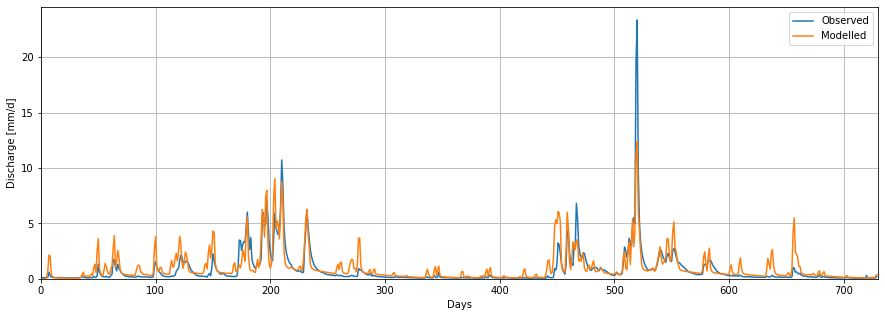

In [20]:
forcing = np.genfromtxt('wark_data/forcingWark.txt', dtype=float, autostrip=True)

# I_max, C_e, S_u_max, beta, P_max, K_f  
Par_Plateau = np.array([3.2, 0.50, 17.40, 0.95, 1.76, 0.91]) 

# I_max, C_e, S_u_max, beta, D, K_f  
Par_Hillslope = np.array([3.25, 0.50, 321.99, 0.99, 0.4, 0.97])

# I_max, C_e, S_u_max, beta, C_max, K_f  
Par_Wetland   = np.array([9.94, 0.50, 53.25, 0.70, 0.65, 0.45])

# K_s, T_lag
Par_Catchment = np.array([0.0281, 2.21])

#landscape percentages
landscape_per= np.array([plateau_per, hillslope_per, wetland_per])

Q_m = FLEXtopo(Par_Plateau, Par_Hillslope, Par_Wetland, Par_Catchment, forcing[:, 3:6], landscape_per)
Q_o = forcing[:, 3]

plt.figure(figsize=[15, 5])
plt.plot(range(0,len(Q_o)), Q_o, label='Observed')
plt.plot(range(0,len(Q_m)), Q_m, label='Modelled')
plt.legend()
plt.grid()
plt.xlabel('Days')
plt.ylabel('Discharge [mm/d]')
plt.xlim(0, len(Q_o))
plt.ylim(0);